<h4>Content</h4>
<ol>
    <li><a href="#introduction">Introduction</a></li>
    <li><a href="#wrangling">Data Wrangling</a>
    <li><a href="#eda">Exploratory Data Analysis</a></li>
</ol>

<a id="introduction"></a>
# Introduction

For this analysis I gathered, cleaned and analyzed data from a Tweet database of Twitter user @dog_rates, also known as We Rate Dogs (<a href="https://en.wikipedia.org/wiki/WeRateDogs">Wikipedia</a>).

A total of three (3) tables were gathered from different sources and manipulated into three (3) final dataframes for an exploratory analysis. These tables contained data from We Rate Dogs' Tweets and image predictions data, which contained the results of a classification made by running the pictures of the rated dogs through a neural network.

The attributes present in the Tweets data and its description can be found in <a href=https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object>Twitter's Developer Documentation</a>.

The attributes present in the image predictions data are:
- jpg_url: url for the image
- img_num: image number that corresponds to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)
- p1: is the algorithm's #1 prediction for the image in the tweet → golden retriever
- p1_conf: is how confident the algorithm is in its #1 prediction → 95%
- p1_dog: is whether or not the #1 prediction is a breed of dog → TRUE
- p2: is the algorithm's second most likely prediction → Labrador retriever
- p2_conf: is how confident the algorithm is in its #2 prediction → 1%
- p2_dog: is whether or not the #2 prediction is a breed of dog → TRUE

In [1]:
import os, sys
import requests
from twitterkeys import *
import tweepy
import json
import re
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import datetime as dt
import time
from collections import Counter
%matplotlib inline

<a id="wrangling"></a>
<h1>Data Wrangling</h1>
<h4>Content</h4>
<ol>
    <li><a href="#gathering">Gathering</a></li>
    <li><a href="#assessment">Assessment</a>
    <li><a href="#cleaning">Cleaning</a></li>
</ol>
<a id="gathering"></a>
<h2>Gathering</h2>
<h4>Content</h4>
<ul>
    <li><a href="#twitterarchive">Twitter Archive</a></li>
    <li><a href="#imagepredictions">Image Predictions</a>
    <li><a href="#furtherdata">Further Twitter Data</a></li>
</ul>

As mentioned above, Udacity provided two sets of data, the Twitter Archive, containing basic data on Tweets, and the Image Predictions data, containing the results of a classification made by running the pictures of the rated dogs through a neural network. 

I downloaded the Twitter archive manually through Udacity’s website and the image predictions using Python requests library.

The work on gathering was made mostly through requests via Twitter API, using Tweepy Library.

<a id="twitterarchive"></a>
#### Twitter Archive

In [2]:
# load twitter archive table
dfa = pd.read_csv('twitter-archive-enhanced.csv')

<a id="imagepredictions"></a>
#### Image Predictions

In [ ]:
# request resource for image predictions using provided url and save content in file

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

with open(os.path.join(os.getcwd(), url.split('/')[-1]), 'wb') as filename:
    filename.write(r.content)

In [3]:
# load image predictions table
dfi = pd.read_csv('image-predictions.tsv', sep='\t')

<a id="furtherdata"></a>
#### Further Twitter Data

To download this data, I looped though the tweet IDs found in `dfa` and got the full data for each Tweet. 

The program was unable to get 25 tweets, generating 25 error messages which were stored in the `errors` dictionary in order to manually or programatically solve them later.

22 errors were due to Twitter API not finding the Tweet for the related id (Error Code 144), 1 error due to non-authorization of the requesting user (Error Code 179) and the other two due to timeout or connection problem. 

At last, I requested these last two again, but I wasn’t able to obtain 23 tweets out of 2356 due to structural limitations (Error Codes 144 and 179).

In [ ]:
# get tweets for each tweet_id in dfa
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

tweet_ids = dfa['tweet_id'].values
errors = {}
tweets = []

for i in tweet_ids:
    while True:
        try:
            tweets.append(api.get_status(i))
        except tweepy.RateLimitError:
            time.sleep(60 * 15)
            continue
        except Exception as e:
            errors[i] = e
        finally:
            break
            
# count my error messages
Counter(map(str, errors.values()))

In [ ]:
# try to get tweets and remove from errors if successful
successful_ids = []

for i, error in errors.items():
    # eliminate error codes '144' and '179'
    if '144' not in str(error) and '179' not in str(error):
        while True:
            try:
                print(f'Trying to dowload {i}')
                tweets.append(api.get_status(i))
                print(f'Downloaded {i}')
                successful_ids.append(i)
            except Exception as e:
                print(f'Error {e} for {i}')
                errors[i] = e
                print('Assigned to', errors[i])
            finally:
                break
                
# delete the error message from errors dictionary
for i in successful_ids:
    del errors[i]

# write list of json files to 'tweet_json.txt'
with open(os.path.join(os.getcwd(), 'tweet_json.txt'),'w') as filename:
    json.dump(tweets, filename)

In [4]:
# load the json archive table
dfj = pd.read_json(os.path.join(os.getcwd(),'tweet_json.txt'))

<a id="assessment"></a>
## Assessment

#### Preparing Dataframes
Before assessing the data, I merged `dfa` and `dfj` into `df`, since they refer to the same instances. This way, the assessment and the cleaning could have a better flow, and this could also avoid duplicated work.

After assessing each duplicated column to see if they were both equal along the whole `df`, I found out that they are, except for obvious cases where `dfj` did not have the corresponding `id` for `dfa`'s `tweet_id` (refer to <a href="#furtherdata">Further Twitter Data</a>). For this reason, I decided to keep the columns of `dfa` by joining a subset of `dfj`, except for `created_at`, which already had the correct `dtype`, instead of `timestamp`.

In [5]:
# create a list to save distinct names of columns of dfj
col = []
for c in dfj.columns:
    if c not in dfa.columns:
        col.append(c)

# merge dfa and the subset dfj[col] into df
df = pd.merge(dfa, dfj[col], how='outer', left_on='tweet_id', right_on='id')

# drop duplicated columns
df.drop(columns=['id', 'id_str', 'created_at'], inplace=True)

<h4>Content:</h4>
<ul>
    <li><a href="#assessingdf">Assessing</a> <code>df</code></li>
    <li><a href="#assessingdfi">Assessing</a> <code>dfi</code></li>
    <li><a href="#quality">Quality Issues</a> <code>df</code></li>
    <li><a href="#tidinessdf">Tidiness Issues</a> <code>df</code></li>
    <li><a href="#qualitydfi">Quality Issues</a> <code>dfi</code></li>
</ul>
<a id="assessingdf"></a>
<h2>Assessing <code>df</code></h2>

In [6]:
dfa.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [7]:
dfj.head()

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",37334,False,NaN,892420643555336193,892420643555336192,...,NaN,NaN,NaN,8008,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,32088,False,NaN,892177421306343426,892177421306343424,...,NaN,NaN,NaN,5940,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,24188,False,NaN,891815181378084864,891815181378084864,...,NaN,NaN,NaN,3928,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",40633,False,NaN,891689557279858688,891689557279858688,...,NaN,NaN,NaN,8169,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,38870,False,NaN,891327558926688256,891327558926688256,...,NaN,NaN,NaN,8850,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [8]:
print('Shape:', df.shape, '\n')
df.info()

Shape: (2356, 40) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 40 columns):
tweet_id                         2356 non-null int64
in_reply_to_status_id            78 non-null float64
in_reply_to_user_id              78 non-null float64
timestamp                        2356 non-null object
source                           2356 non-null object
text                             2356 non-null object
retweeted_status_id              181 non-null float64
retweeted_status_user_id         181 non-null float64
retweeted_status_timestamp       181 non-null object
expanded_urls                    2297 non-null object
rating_numerator                 2356 non-null int64
rating_denominator               2356 non-null int64
name                             2356 non-null object
doggo                            2356 non-null object
floofer                          2356 non-null object
pupper                           2356 non-null object
puppo          

In [9]:
df.isnull().sum().sort_values(ascending=False)

contributors                     2356
coordinates                      2356
geo                              2356
place                            2355
quoted_status                    2332
quoted_status_id                 2330
quoted_status_id_str             2330
in_reply_to_status_id_str        2279
in_reply_to_screen_name          2279
in_reply_to_user_id_str          2279
in_reply_to_user_id              2278
in_reply_to_status_id            2278
retweeted_status                 2192
retweeted_status_timestamp       2175
retweeted_status_user_id         2175
retweeted_status_id              2175
extended_entities                 541
possibly_sensitive                161
possibly_sensitive_appealable     161
expanded_urls                      59
user                               28
entities                           28
truncated                          28
favorite_count                     28
retweeted                          28
retweet_count                      28
lang        

In [10]:
df['name'].value_counts()

None         745
a             55
Charlie       12
Cooper        11
Oliver        11
Lucy          11
Penny         10
Tucker        10
Lola          10
Bo             9
Winston        9
the            8
Sadie          8
an             7
Buddy          7
Daisy          7
Toby           7
Bailey         7
Koda           6
Jax            6
Rusty          6
Scout          6
Leo            6
Stanley        6
Oscar          6
Milo           6
Bella          6
Dave           6
Jack           6
Larry          5
            ... 
Devón          1
Arnold         1
Glenn          1
Rodney         1
Baron          1
Coleman        1
Eevee          1
Kloey          1
DonDon         1
Mosby          1
Dobby          1
Noosh          1
Pippin         1
Willow         1
Sparky         1
Jameson        1
Tino           1
Aqua           1
Gustav         1
Malikai        1
Hanz           1
Rizzo          1
Jimbo          1
Sprinkles      1
Rascal         1
Geno           1
Sora           1
Severus       

In [11]:
df['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [12]:
df['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [13]:
df['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [14]:
df['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [15]:
df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [16]:
df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [17]:
# get all the possible invalid rating_numerator
for numerator in dfa['rating_numerator'].value_counts().index[6:]:
    for index, value in dfa[(dfa['rating_numerator'] == numerator)]['text'].iteritems():
        print(index, numerator, value, '\n')

387 7 I was going to do 007/10, but the joke wasn't worth the &lt;10 rating 

462 7 RT @dog_rates: Meet Herschel. He's slightly bigger than ur average pupper. Looks lonely. Could probably ride 7/10 would totally pet https:/… 

814 7 Another pic without a dog in it? What am I supposed to do? Rate the carpet? Fine I will. 7/10 looks adequately comfy https://t.co/OJZQ6I4gGd 

896 7 Meet Toby. He has a drinking problem. Inflatable marijuana plant in the back is also not a good look. 7/10 cmon Toby https://t.co/Cim4DSj6Oi 

998 7 This sherk must've leapt out of the water and into the canoe, trapping the human. Won't even help paddle smh. 7/10 https://t.co/KubWEqOIgO 

1029 7 This is Percy. He fell asleep at the wheel. Irresponsible af. 7/10 absolute menace on the roadway https://t.co/QHbvtvaw8E 

1045 7 This is Harold. He looks slippery af. Probably difficult to hug. Would still try tho. 7/10 great with kids I bet https://t.co/EVuqdEO66N 

1239 7 This is Steven. He's inverted af. Also very 

In [18]:
# get all the possible invalid rating_denominator
for denominator in dfa['rating_denominator'].value_counts().index[1:]:
    for index, value in dfa[dfa['rating_denominator'] == denominator]['text'].iteritems():
        print(index, denominator, value, '\n')

784 11 RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/… 

1068 11 After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ 

1662 11 This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5 

1202 50 This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq 

1274 50 From left to right:
Cletus, Jerome, Alejandro, Burp, &amp; Titson
None know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK 

1351 50 Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa 

1254 80 Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12 

1843 80 Here we have an entire platoon of puppers. Tot

In [19]:
list(df['expanded_urls'].values)

['https://twitter.com/dog_rates/status/892420643555336193/photo/1',
 'https://twitter.com/dog_rates/status/892177421306343426/photo/1',
 'https://twitter.com/dog_rates/status/891815181378084864/photo/1',
 'https://twitter.com/dog_rates/status/891689557279858688/photo/1',
 'https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1',
 'https://twitter.com/dog_rates/status/891087950875897856/photo/1',
 'https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1',
 'https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1',
 'https://twitter.com/dog_rates/status/890609185150312448/photo/1',
 'https://twitter.com/dog_rates/status/890240255349198849/photo/1',
 'https://twitter.com/dog_rates/status/890006608113172480/photo/1,https://twitter.com/dog_rates/status/890006608113172480/photo/1',
 'https://twitte

In [20]:
print(df['possibly_sensitive_appealable'].value_counts())
print(df['possibly_sensitive'].value_counts())

0.0    2195
Name: possibly_sensitive_appealable, dtype: int64
0.0    2195
Name: possibly_sensitive, dtype: int64


In [21]:
for i in (df[df['in_reply_to_status_id'].notnull()].text):
    print(i)

@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution
@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
@RealKentMurphy 14/10 confirmed
@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs
@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10
Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen
@Marc_IRL pixelated af 12/10
THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA
@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10
@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your 

In [22]:
for i in (df[df['retweeted_status'].notnull()].text):
    print(i)

RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo
RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5
RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…
RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below

https:/…
RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…
RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G
RT @dog_rates: This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly https://t.c…
RT @dog_rates: This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra bel

<a id="assessingdfi"></a>
<h3>Assessing <code>dfi</code></h3>

In [23]:
print('Shape:', dfi.shape, '\n')
dfi.info()

Shape: (2075, 12) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
dfi['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [25]:
dfi.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [26]:
dfi[dfi.img_num == 4].head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
144,668623201287675904,https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg,4,Chihuahua,0.708163,True,Pomeranian,0.091372,True,titi,0.067325,False
779,689905486972461056,https://pbs.twimg.com/media/CZMJYCRVAAE35Wk.jpg,4,Pomeranian,0.943331,True,Shetland_sheepdog,0.023675,True,chow,0.007165,True
1024,710588934686908417,https://pbs.twimg.com/media/CdyE2x1W8AAe0TG.jpg,4,Pembroke,0.982004,True,Cardigan,0.008943,True,malamute,0.007550,True
1161,734787690684657664,https://pbs.twimg.com/media/CjJ9gQ1WgAAXQtJ.jpg,4,golden_retriever,0.883991,True,chow,0.023542,True,Labrador_retriever,0.016056,True
1286,750868782890057730,https://pbs.twimg.com/media/CmufLLsXYAAsU0r.jpg,4,toy_poodle,0.912648,True,miniature_poodle,0.035059,True,seat_belt,0.026376,False


In [27]:
dfi.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
German_shepherd               20
Siberian_husky                20
Staffordshire_bullterrier     20
web_site                      19
Cardigan                      19
teddy                         18
beagle                        18
Maltese_dog                   18
Eskimo_dog                    18
Shetland_sheepdog             18
Rottweiler                    17
Shih-Tzu                      17
Lakeland_terrier              17
Italian_greyhound             16
kuvasz                        16
          

In [28]:
dfi.p2.value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
French_bulldog                     41
Chesapeake_Bay_retriever           41
toy_poodle                         37
cocker_spaniel                     34
miniature_poodle                   33
Siberian_husky                     33
beagle                             28
Pembroke                           27
collie                             27
Eskimo_dog                         27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
chow                               20
toy_terrier                        20
miniature_pinscher                 20
malinois                           20
Samoyed                            20
Norwegian_elkhound                 19
Boston_bull                        19
Staffordshir

In [29]:
dfi.p3.value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
cocker_spaniel                    31
beagle                            31
Pomeranian                        29
Pekinese                          29
toy_poodle                        29
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
Pembroke                          27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
pug                               23
Cardigan                          23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
b

<a id="quality"></a>

### Quality Issues `df`

#### Incomplete Data

- `coordinates`: 2356 missing values
- `contributors`: 2356 missing values
- `geo`: 2356 missing values
- `place`: 2355 missing values
- `quoted_status`: 2332 missing values
- `quoted_status_id_str`: 2330 missing values
- `quoted_status_id`: 2330 missing values
- `in_reply_to_status_id`: 2278 missing values
- `in_reply_to_user_id`: 2278 missing values
- `retweeted_status`: 2192 missing values
- `retweeted_status_timestamp`: 2175 missing values
- `retweeted_status_id`: 2175 missing values
- `retweeted_status_user_id`: 2175 missing values
- `extended_entities`: 538 missing values
- `possibly_sensitive_appealable`: 157 missing values
- `possibly_sensitive`: 157 missing values
- `expanded_urls`: 59 missing values
- `truncated`: 23 missing values
- `user`: 23 missing values
- `entities`: 23 missing values
- `favorite_count`: 23 missing values
- `retweeted`: 23 missing values
- `retweet_count`: 23 missing values
- `lang`: 23 missing values
- `is_quote_status`: 23 missing values
- `favorited`: 23 missing values

#### Invalid Data
- `name` has invalid names (None, a, an, all, the, etc.)
- `doggo`, `puppo`, `pupper` and `floofer` have many values set as 'None' (str)

#### Inaccurate Data
- `rating_numerator` and `rating_denominator` were sometimes incorrectly registered:
    - at label `784`, `1068` and `1662`for denominator = 11
    - at label `1202` for denominator = 50
    - at label `1165` for denominator = 20
    - at label `516` for denominator = 7
    - at label `313` for denominator = 0

#### Inconsistent Data
- `datatypes`:
    - change `rating_numerator` and `rating_denominator` to `numpy.int`
    - change `timestamp` to `datetime`
    - change `favorite_count` and `retweet_count` to `numpy.int`
- `source` has html tags around its content

<a id="tidinessdf"></a>
### Tidiness Issues `df`
- `doggo`, `puppo`, `pupper` and `floofer` refer to the type of dog and should be in one `type` column
- `expanded_urls` has some instances with more than one URI
- `text` has the short URI in all instances, which could have a column of its own
- `df_clean` and `dfi` should be merged 

<a id="qualitydfi"></a>
<h3>Quality Issues <code>dfi</code></h3>

#### Inconsistent Data
- most breed names are inconsistent, it is hard to read through (cleaning this, however, is not very efficient, as it is not relevant to the analysis and it could raise other problems)

<a id="cleaning"></a>
<h2>Cleaning</h2>

In [30]:
# create a copy to perform cleaning
df_clean = df.copy()

<h4>Content:</h4>

<ul>
    <li><a href="#quality">Dealing with Incomplete Data</a></li>
    <li><a href="#untidy">Dealing with Untidy Data</a></li>
    <li><a href="#invalid">Dealing with Invalid, Inaccurate and Inconsistent Data</a></li>
</ul>

<a id="incomplete"></a>
### Dealing with Incomplete Data

#### Describe

For dealing with incomplete data, first I **(a)** cleaned the attributes that do not qualify any of the instances and that are unwanted, and so I intended to drop -- which may not result in the exclusion of instances, **(b)** cleaned the attributes that qualify an instance in any way -- which may result in the exclusion of instances, and **(c)** cleaned the attributes that I needed .

The attributes `favorite_count` and `retweet_count` are interesting to the analysis and therefore should be kept and the missing values should be left as they are. Any filling of the missing values could bias a posterior analysis.

The attributes `favorited`, `retweeted`, `truncated` and `lang` do not tell much and are not important for this analysis. They should be dropped.

The the attributes are missing due to the errors encountered while downloading some of the the twitter data with twitter API (refer to <a href="#gathering">Gathering</a>), hence why they have 23 missing values. There is no point in dropping their instances, as they still have valid data in other columns inherited from `dfa`.

The attributes `coordinates`, `contributors`, `geo` and `place` have structural missing data, meaning they have missing data for all instances, or for most of the instances, because they simple were not registered by Twitter or provided by Twitter API. As they do not represent any attribute that qualifies the status (refer to <a href="#introduction">Introduction</a>), there is really no point in keeping them in `df`.

The attributes `entities`, `extended_entities` and `user` are `pandas.Series` of nested unserialized JSON objects. As some of the instances have `np.nan` value for this attribute, the function `json_normalize` does not function as expected. Just for the sake of this assessment, although not ideal, the `np.nan` values were forward-filled so to be able to run the function (I could not find anything in documentations to avoid doing this). After examining these attributes, the only information that seem relevant are the URLs found in `extended_entities['media']` and `entities['urls']`, although not relevant for the analysis *per se*, but for the sake of filling `df`'s missing URLs in `expanded_urls`. I will store these attributes as `pandas.Series` and come back to them if needed.

The attributes `possibly_sensitive_appealable` and `possibly_sensitive` indicate if a URL contained in a Tweet may contain content or media identified as sensitive content. Other than `np.nan`, the only value for these columns in `df` is `0.0`. Therefore, not a problem if I just drop the columns.

The attributes `quoted_status`, `quoted_status_id_str`, `quoted_status_id` and `is_quote_status` qualify the Tweet as a quote Tweet. After examining quote Tweets, I realized they are very similar to regular Tweets. They generally won't have some information as of `name` attribute, but nothing that will hinder this analysis, so I will just drop the columns.

#### Code

In [31]:
# store the nested JSON objects in 'entities' and 'extended entities' 
# and drop the columns
user = df['user'].copy()
user = user.fillna(method='ffill')
user = pd.io.json.json_normalize(user)

entities = df['entities'].copy()
entities = entities.fillna(method='ffill')
entities = pd.io.json.json_normalize(entities)

extended_entities = df['extended_entities'].copy()
extended_entities = extended_entities.fillna(method='ffill')
extended_entities = pd.io.json.json_normalize(extended_entities)

df_clean.drop(columns=['favorited', 'retweeted', 'truncated', 'lang', 'coordinates', 'contributors', 
                       'geo', 'place', 'entities', 'extended_entities', 'user', 'possibly_sensitive_appealable', 
                       'possibly_sensitive', 'quoted_status', 'quoted_status_id_str', 'quoted_status_id', 
                       'is_quote_status'],
              inplace=True)

#### Test

In [32]:
columns = ['favorited', 'retweeted', 'truncated', 'lang', 'coordinates', 
           'contributors', 'geo', 'place', 'entities', 'extended_entities', 
           'user', 'possibly_sensitive_appealable', 'possibly_sensitive', 
           'quoted_status', 'quoted_status_id_str', 'quoted_status_id', 'is_quote_status']

assert all(column not in df_clean.columns for column in columns)

#### Describe

The attributes `in_reply_to_user_id_str`, `in_reply_to_screen_name`, `in_reply_to_status_id`, `in_reply_to_status_id_str` and `in_reply_to_user_id` qualify the Tweet as a Reply. Replies are not needed in this analysis and so I will drop the instances and the attributes where Replies are not `np.nan`.

#### Code

In [33]:
# get instances where replies columns are not null
condition = df_clean.loc[:,['in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id_str', 
                            'in_reply_to_status_id', 'in_reply_to_user_id']].notnull().any(axis=1)

replies = df_clean[condition]

# select a subset of df_clean where replies are null and drop the columns for replies
df_clean = df_clean[~condition]

df_clean.drop(columns=['in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id_str', 
                       'in_reply_to_status_id', 'in_reply_to_user_id'], inplace=True)

#### Test

In [34]:
assert df.shape[0] == df_clean.shape[0] + replies.shape[0]

#### Describe 
The attributes `retweeted_status`, `retweeted_status_timestamp`, `retweeted_status_id` and `retweeted_status_user_id` qualify Tweets as Retweets, which could be important to this analysis.

After evaluating the data for Retweets, I realized that most of the Retweets are Retweets of statuses published by @dog_rates. Out of a total of 181 retweets, 156 were statuses of @dog_rates retweeted by other people, which I found out by realizing that when `retweeted_status_user_id` indicates the id 4196983835, which is the user id of @dog_rates, the same Tweet exists in `df` as not a retweet, meaning that there are co-existing identical Retweets and Tweets. 

I will treat these 156 instances as "duplicated" and will drop them. 

As to the remaining 25 retweets, they are retweets of other people, which are not important to this analysis, and I will drop these instances as well.

#### Code

In [35]:
# more of assessing the dataframe
# create a dataframe for retweets and investigate if they should be analyzed
condition = df_clean.loc[:,['retweeted_status', 'retweeted_status_id', 'retweeted_status_user_id', 
                            'retweeted_status_timestamp']].notnull().any(axis=1)
retweets = df_clean[condition]

# separate between duplicated retweets and not duplicated retweets
retweets.loc[:, 'retweeted_status_user_id'] = retweets.loc[:, 'retweeted_status_user_id'].astype(int)
retweets.loc[:, 'retweeted_status_id'] = retweets.loc[:, 'retweeted_status_id'].astype(int)

dup_rt = retweets[retweets['retweeted_status_user_id'] == 4196983835]
not_dup_rt = retweets[retweets['retweeted_status_user_id'] != 4196983835]

# clean the retweets from dfa_clean
df_clean = df_clean[~condition]

df_clean.drop(columns=['retweeted_status', 'retweeted_status_id', 'retweeted_status_user_id', 
                       'retweeted_status_timestamp'], inplace=True)

df_clean.reset_index(drop=True, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Test

In [36]:
assert df.shape[0] == df_clean.shape[0] + replies.shape[0] + retweets.shape[0]

#### Describe
The attribute `expanded_urls` have no use in the analysis, but could be in `df` for sake of completion. After dropping some instances due to missing or unwanted data I was left with 3 missing URLs (out of 59 initially), so I felt no need to drop them afterwards. I would still be able to extract the missing values from `extended_entities` or `entities`.

#### Code

In [37]:
# get the labels for which df_clean.expanded_urls are null
labels = df_clean[df_clean.expanded_urls.isnull()].index

# get the urls and verify them
urls = pd.Series([json_normalize(extended_entities.iloc[label, 0])['expanded_url'].values[0] for label in labels], 
                 index=labels)

# assign to df_clean
df_clean.loc[labels, 'expanded_urls'] = urls

#### Test

In [38]:
assert not len(df_clean[df_clean.expanded_urls.isnull()])

<a id="untidy"></a>
### Dealing with Untidy Data
- `expanded_urls` has some instances with more than one URI
- `text` has the short URI in all instances, which could have a column of its own
- `df_clean` and `dfi` should be merged 

#### Describe
One of the aspects of tidy data is that each dataframe forms an observation unit, with related variables. `df_clean` would be better organized if it was merged with `dfi`  into `master`. I generated some missing data because of the previous shape of `dfi`. This should not hinder the analysis, however.

#### Code

In [39]:
master = pd.merge(df_clean, dfi, how='left', on='tweet_id')

#### Test

In [40]:
master.shape

(2097, 25)

In [41]:
master.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'favorite_count', 'retweet_count', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog'],
      dtype='object')

#### Describe
Some of the `expanded_urls` have more than one url in the text, separated by commas. Generally these different urls refer to the Tweet and to a fund raising campaign to help the dog. 

I will cleaned this, so the `expanded_urls` have only one url that links to the original twitter status, when possible.

#### Code

In [42]:
# create a series with every string of urls from df_tweets and fill the nulls with an empty string
clean_urls = master['expanded_urls'].fillna('')

# split all the strings into a list
clean_urls = clean_urls.str.split(',')

# get the distinct urls for each row
clean_urls = clean_urls.apply(set)

# create a dataframe for all distinct urls
clean_urls_df = pd.DataFrame([url for url in clean_urls], columns=['A', 'B'])

# assign to column 'B' only the urls that are from twitter
clean_urls_df['B'] = clean_urls_df['B'].where(clean_urls_df['B'].str.contains('twitter.com'), clean_urls_df['A'])

# assign the right expanded_urls to df_tweets
master.loc[:, 'expanded_urls'] = clean_urls_df['B']

#### Test

In [43]:
# no output if there is only one link in the expanded_urls
assert master['expanded_urls'].apply(lambda x: len(x.split(','))).all()

#### Describe
There is no need for `text` to have an URI thus the short URIs should be extracted.

#### Code

In [44]:
# create a dataframe to manipulate the text attribute
clean_text = pd.DataFrame({'A': master['text']})

# fix eventual newlines in text, which are creating a problem with the extraction further
clean_text['A'] = clean_text['A'].str.replace('\n', ' ')

# extract text + two URIs (if possible)
clean_text[['B', 'C', 'D']] = clean_text['A'].str.extract(r'(.*?)\s*(https.*)?\s(https.*)')

In [45]:
# insert text and short_url in master
master['text'] = clean_text['B']
master['short_url'] = clean_text['D']

In [46]:
# some text has been wrongfully cleaned because it did not follow the pattern for other 'text'
# I will assign manually the 'text' that has been wrongfully cleaned
labels = master[master.text.isnull()].index
master.loc[labels, 'text'] = df.loc[labels, 'text']

#### Test

In [47]:
# assert no text was wrongfully cleaned to Null value or ''
assert master['text'].isnull().sum() == 0 and (master['text'] == '').sum() == 0

#### Describe
I created a unique column for type of dog, as there is no need for having multiple columns to describe the type of dog.

I realized that there are, sometimes, more than one type of dog to one id, which I found odd and maybe it was an indication of invalid data.

Looking more into it, by checking the pictures, I realized that there were two dogs in the picture (or maybe none), thus the reference for two types of dogs.

It still does not make sense to leave the two. I have seen other Tweets that have more than one 'pupper' and in no way it was assigned the type pupper more than one time.

Therefore, I will just call these 'None' and have in mind that it is possible that 'None' type is also for when there is more than one dog.

In [48]:
# check where there are more than one type of dogs for one dog entry
dog_types = ['puppo', 'doggo', 'pupper', 'floofer']
master[(master[dog_types] != 'None').sum(axis=1) > 1][dog_types]

,puppo,doggo,pupper,floofer
154,puppo,doggo,None,None
161,None,doggo,None,floofer
358,None,doggo,pupper,None
416,None,doggo,pupper,None
446,None,doggo,pupper,None
536,None,doggo,pupper,None
562,None,doggo,pupper,None
689,None,doggo,pupper,None
748,None,doggo,pupper,None
848,None,doggo,pupper,None


In [49]:
# assign Nan to all of the values that are invalid
labels = master[(master[dog_types] != 'None').sum(axis=1) > 1].index

for t in dog_types:
    master.loc[labels, t] = np.nan

In [50]:
# create a type column and assign the values to it
master[dog_types] = master[dog_types].replace('None', np.nan)

master['type'] = master['doggo'].fillna(master['floofer'])
master['type'] = master['type'].fillna(master['pupper'])
master['type'] = master['type'].fillna(master['puppo'])

master['type'] = master['type'].fillna('None')

In [51]:
# drop the other columns
master = master.drop(columns=dog_types)

#### Test

In [52]:
# test if everything was correctly assigned to type
assert 2*len(labels) + master['type'][master['type'] != 'None'].value_counts().sum() == (df_clean[dog_types] != 'None').sum(axis=1).sum()

<a id="invalid"></a>
### Dealing with Invalid, Inaccurate and Inconsistent Data

#### Invalid Data
- `name` has invalid names (None, a, an, all, the, etc.)
- `doggo`, `puppo`, `pupper` and `floofer` have many values set as 'None' (str)

#### Inaccurate Data
- `rating_numerator` and `rating_denominator` were sometimes incorrectly registered:
    - at label `784`, `1068` and `1662`for denominator = 11
    - at label `1202` for denominator = 50
    - at label `1165` for denominator = 20
    - at label `516` for denominator = 7
    - at label `313` for denominator = 0

#### Inconsistent Data
- `datatypes`:
    - change `rating_numerator` and `rating_denominator` to `numpy.int`
    - change `timestamp` to `datetime`
    - change `favorite_count` and `retweet_count` to `numpy.int`
- `source` has html tags around its content

#### Describe

Some of the names in `df` are invalid -- e.g. None, such, a, an, all, the. This could mean that the program that identified names from this column mistakenly picked other parts of the text and set it as a name. I believe this can be fixed by gathering valid names from the text.

The program that cleaned the `text` string to get a name, catches the first name after 'is', as in 'This is' or 'Here is'.

I was able to extract some of the names by using patterns with regex. The other wrong names, the ones that are not written in the `text`, I will change to None.

#### Code

In [53]:
# most names that are not actually names do not have the first letters in uppercase,
# let's grab those names and respective labels and store them in a dictionary
not_names = {}

for k, v in master.name.iteritems():
    if v.islower():
        if not isinstance(not_names.get(v), list):
            not_names[v] = []
        not_names[v].append(k)

# append 'None' manually
not_names['None'] = []
for l in master['name'][master['name'] == 'None'].index:
    not_names['None'].append(l)

# total values that do not have names
not_names_labels = [label for label_list in not_names.values() for label in label_list]
print(f'Total values that are not names: {len(not_names_labels)}')

Total values that are not names: 707


In [54]:
# set all not_names to 'None'
master.loc[not_names_labels, 'name'] = 'None'

def get_right_names(*patterns):

    df_lst = []

    for pattern in list(patterns):
        pattern = re.compile(pattern)
        df_names = pd.concat(pd.DataFrame(data=master[master['name'] == key]['text'].str.extract(pattern).values,
                                          index=master[master['name'] == key]['text'].index,
                                          columns=['name']) for key in not_names.keys())
        
        df_lst.append(df_names)
    
    return pd.concat(df_lst).dropna()

# call the functions with some patterns
right_names = get_right_names('That is (\w+)', 'name\sis\s(\w+)', 'named\s(\w+)')

# assign the right names to dfa_clean
master.loc[right_names.index, 'name'] = right_names['name']

#### Test

In [55]:
# check how many names I was able to get from the text
remaining_not_names = pd.concat(pd.DataFrame(data=master[master['name'] == key]) for key in not_names.keys())
print(f'Total names I was able to recover: {len(not_names_labels) - remaining_not_names.shape[0]}')
right_names

Total names I was able to recover: 31


,name
783,Quizno
32,Howard
140,Zoey
657,Zoey
1441,Thea
1496,Sabertooth
2009,Big
2029,Daryl
1610,Wylie
1704,Kip


#### Describe
Since some of the values seemed to be invalid, I extracted the correct values and replace the `rating_numerator` and `rating_denominator`. I also fixed the type for the ratings to `np.float`, as some of the ratings are decimals.

One could say that there is no need for `text` to have the `rating_numerator` and `rating_denominator`, and that would be untidy data. However, some of the texts seem more complete with the ratings and hence I left it the way it is.

#### Code

In [56]:
# extract ratings for most instances
clean_text[['E', 'F']] = clean_text['A'].str.extract(r'.*?(\d{1,4})/(\d{1,4})')

# for some instances, text has more than one pattern that match the rating pattern 'X/X',
# store these in G and H
clean_text[['G', 'H']] = clean_text['B'].str.extract(r'.*?\d*/\d*.*?(\d*)/(\d*)')

# create two columns with the right values and assign it to dfa_clean
clean_text['G'] = clean_text['G'].where((clean_text['G'].notnull())&(clean_text['G'] != ''), clean_text['E'])
clean_text['H'] = clean_text['H'].where((clean_text['H'].notnull())&(clean_text['H'] != ''), clean_text['F'])

master['rating_numerator'] = clean_text['G']
master['rating_denominator'] = clean_text['H']

In [57]:
# extract decimal part of ratings
decimal_ratings = clean_text[clean_text.A.str.contains(r'(\d+\.\d*\/\d+)')]['A']
clean_text[['I', 'J']] = decimal_ratings.str.extract(r'(\d+\.\d*)\/(\d+)')

master.loc[decimal_ratings.index, ['rating_numerator', 'rating_denominator']] = clean_text.loc[decimal_ratings.index, ['I', 'J']]
master.loc[decimal_ratings.index, 'rating_numerator'] = clean_text.loc[decimal_ratings.index, 'I']
master.loc[decimal_ratings.index, 'rating_denominator'] = clean_text.loc[decimal_ratings.index, 'J']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [58]:
# change dtype to np.float
master['rating_numerator'] = master['rating_numerator'].astype(np.float)
master['rating_denominator'] = clean_text['H'].astype(np.float)

#### Test

In [59]:
# check how many numerators were changed
test_numerator = master['rating_numerator'].values != df_clean.loc[master.index, 'rating_numerator']
test_denominator = master['rating_denominator'].values != df_clean.loc[master.index, 'rating_denominator']

print(f'{test_numerator.sum()} numerators were changed.')
print(f'{test_denominator.sum()} denominators were changed.')

30 numerators were changed.
5 denominators were changed.


In [60]:
# testing for the identified wrong ratings
assert master[master['rating_denominator'] == '11'].all().all()
assert master[master['rating_numerator'] == '13'].all().all()
assert master[master['text'].str.contains('Happy 4/20', na=False)].all().all()

/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [61]:
# this was not cleansed because no rating was given
# I have the choice to assign it manually or leave the rating as it is
master[master['text'].str.contains('24/7', na=False)]

# I will assign the ratings manually
master.loc[516,'rating_numerator'] = 10
master.loc[516,'rating_denominator'] = 10

In [62]:
master[['rating_numerator', 'rating_denominator']].dtypes

rating_numerator      float64
rating_denominator    float64
dtype: object

#### Describe
The attribute `source` has html tags in it. I extracted the content of the tag.

#### Code

In [63]:
# extract the content and assign to master
extract = master.source.str.extract(r'<.*?>(.*)<.*?>')

master['source'] = extract[0]

#### Test

In [64]:
# this should give an idea of the values
master['source'].value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

#### Describe

I changed `timestamp` to datetime to be able to manipulate as time and get accurate analysis.

#### Code

In [65]:
master['timestamp'] = pd.to_datetime(master['timestamp'])

#### Test

In [66]:
master.timestamp.dtype

datetime64[ns, UTC]

#### Describe

I changed `favorite_count` and `retweet_count` to `Int64`.

#### Code

In [67]:
master['favorite_count'] = master['favorite_count'].astype('Int64')

master['retweet_count'] = master['retweet_count'].astype('Int64')

#### Test

In [68]:
master.retweet_count.dtype

Int64Dtype()

In [69]:
master.favorite_count.dtype

Int64Dtype()

### Save to `.csv`

In [70]:
# save master df to .csv
master.to_csv(os.path.join(os.getcwd(),'twitter_archive_master.csv'), index=False)

<a id="eda"></a>
# Exploratory Data Analysis

#### What are the most common names for dogs?

In [71]:
master.name.value_counts()[1:16]

Lucy       11
Charlie    11
Cooper     10
Oliver     10
Penny       9
Tucker      9
Winston     8
Sadie       8
Lola        8
Toby        7
Daisy       7
Bo          6
Stanley     6
Bella       6
Koda        6
Name: name, dtype: int64

> Lucy is the most common name of dogs found in We Rate Dogs, followed by Charlie, Oliver, Cooper, Penny.

#### What source was mostly used to post a Tweet?

In [72]:
master.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

> We can see that, by far, the most used source by We Rate Dogs is the Twitter for iPhone.

#### Which types of dogs appears the most in Tweets?

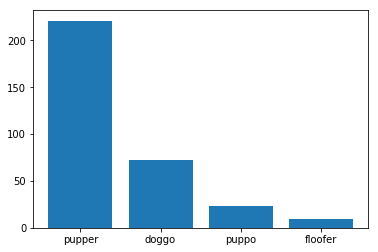

In [73]:
not_none = master['type'][(master.type != 'None')]
plt.bar(not_none.value_counts().index, not_none.value_counts().values);

> The types of dogs that most appear in publications of this Tweet account is the pupper.

#### Out of these types, which types people seem to like the most on average?

In [74]:
not_none_ids = master.iloc[not_none.index, [0, 4]]

dog_types =  pd.merge(left=master[['tweet_id', 'favorite_count', 'retweet_count']], 
                      right=master.iloc[not_none.index, [0, 4]], 
                      how='inner', 
                      on='tweet_id')

In [75]:
master.groupby('type').mean()[['favorite_count', 'retweet_count']]

,favorite_count,retweet_count
type,,
None,8254.976177,2464.693137
doggo,18054.591549,6271.704225
floofer,10412.888889,3789.333333
pupper,6784.627273,2218.722727
puppo,21365.086957,6159.782609


> On average, people seem to like more pictures of puppos, but retweet more pictures of doggos.

#### How have the interactions with the We Rate Dogs Twitter increased over the years?

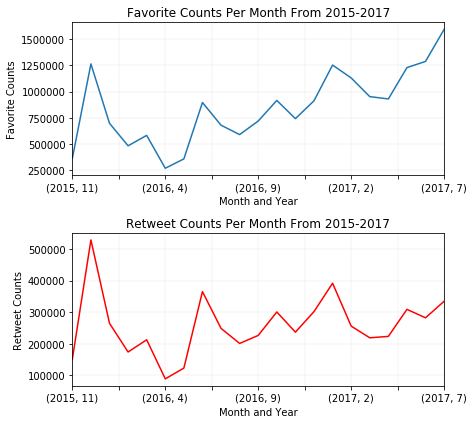

In [76]:
fig = plt.figure(figsize=(12,6))

data = master.groupby([master['timestamp'].dt.year, master['timestamp'].dt.month]).sum()

# subplot 1
sub_1 = plt.subplot(2, 2, 1)
plt.title('Favorite Counts Per Month From 2015-2017')

d1 = data['favorite_count'][:-1]

plt1 = d1.plot()

plt1.set_xlabel('Month and Year')
plt1.set_ylabel('Favorite Counts')

plt.grid(True, linewidth=0.15)

# subplot 2
sub_2 = plt.subplot(2, 2, 3)
plt.title('Retweet Counts Per Month From 2015-2017')

d2 = data['retweet_count'][:-1]

plt2 = d2.plot(color='r')

plt2.set_xlabel('Month and Year')
plt2.set_ylabel('Retweet Counts')

plt.grid(True, linewidth=0.15)

plt.tight_layout();

> For the analyzed period, the favorite counts have consistently been in an upwards trend from 2016 to mid-2017. The same does not happen to retweet counts, which seem to be in a sideways trend.

#### What breed people seem to like the most?

In [ ]:
identified_dogs = master[(master.p1_conf > 0.9)&(master.p1_dog == True)]

identified_dogs.groupby('p1').mean().sort_values('favorite_count', ascending=False).iloc[:5,0]

> It appears that the five breeds that people like the most on average are, in this order, Leonbergs, Great Pyrenees, French Bulldogs, Afghan Hounds and Pembroke.

#### Credits
No code was copied from anywhere in the internet. However, consultation to the following source was made:
- stackoverflow
- Pandas Documentation
- Matplotlib Documentation